# Gamut Mapping - Ramblings 01


In [1]:
from __future__ import division, unicode_literals

import colour
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import reduce

COLOUR_STYLE = colour.plotting.colour_style()
COLOUR_STYLE.update({
    'figure.figsize': (11, 11),
    'legend.framealpha':
    colour.plotting.COLOUR_STYLE_CONSTANTS.opacity.low
})

plt.style.use(COLOUR_STYLE)

plt.style.use('dark_background')

colour.utilities.describe_environment()

colour.utilities.filter_warnings(*[True] * 4);

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.7.6 (default, Dec 30 2019, 19:38:26)                       *
*                [Clang 11.0.0 (clang-1100.0.33.16)]                          *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : v0.3.15-126-gd9ef0a5a                                        *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.8.0                                                       *
*       matplotlib : 3.0.3                                                    *
*       numpy : 1.18.4                                                        *
*       scipy : 1.4.1                   

## Colour Wheel Generation

In [2]:
def colour_wheel(samples=1024, clip_circle=True, method='Colour'):
    xx, yy = np.meshgrid(
        np.linspace(-1, 1, samples), np.linspace(-1, 1, samples))

    S = np.sqrt(xx ** 2 + yy ** 2)    
    H = (np.arctan2(xx, yy) + np.pi) / (np.pi * 2)

    HSV = colour.utilities.tstack([H, S, np.ones(H.shape)])
    RGB = colour.HSV_to_RGB(HSV)

    if clip_circle == True:
        RGB[S > 1] = 0
        A = np.where(S > 1, 0, 1)
    else:
        A = np.ones(S.shape)

    if method.lower()== 'matplotlib':
        RGB = colour.utilities.orient(RGB, '90 CW')
    elif method.lower()== 'nuke':
        RGB = colour.utilities.orient(RGB, 'Flip')
        RGB = colour.utilities.orient(RGB, '90 CW')

    R, G, B = colour.utilities.tsplit(RGB)
    
    return colour.utilities.tstack([R, G, B, A])

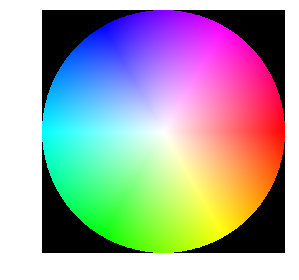

In [3]:
COLOUR_WHEEL = colour_wheel(method='Nuke');

colour.plotting.plot_image(COLOUR_WHEEL);

## Compression Function

In [4]:
def tanh_compression_function(x, a=0.8, b=1 - 0.8):
    x = colour.utilities.as_float_array(x)

    return np.where(x > a, (a + b * np.tanh((x - a) / b)), x)

## ACES2065-1 Colour Wheel

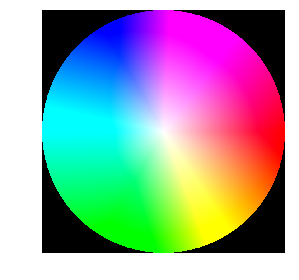

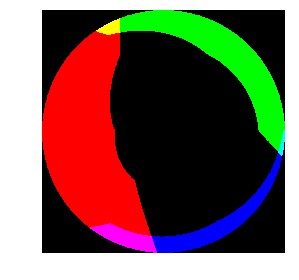

In [5]:
COLOUR_WHEEL_sRGB = colour.RGB_to_RGB(
    COLOUR_WHEEL,
    colour.models.ACES_2065_1_COLOURSPACE,
    colour.models.sRGB_COLOURSPACE)

colour.plotting.plot_image(COLOUR_WHEEL_sRGB);

colour.plotting.plot_image(np.where(COLOUR_WHEEL_sRGB < 0, 1, 0));

## Gamut Mapping on Saturation in HSV Colourspace

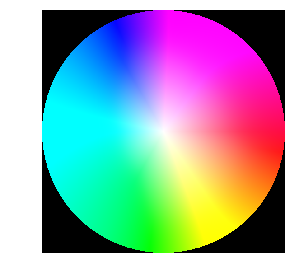

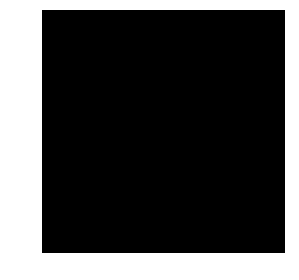

In [6]:
H, S, V = colour.utilities.tsplit(
    colour.RGB_to_HSV(COLOUR_WHEEL_sRGB))

HSV = colour.utilities.tstack([H, tanh_compression_function(S), V])

COLOUR_WHEEL_sRGB_GM_1 = colour.HSV_to_RGB(HSV)

colour.plotting.plot_image(COLOUR_WHEEL_sRGB_GM_1);

colour.plotting.plot_image(np.where(COLOUR_WHEEL_sRGB_GM_1 < 0, 1, 0));

## Gamut Mapping on Chroma in HCL Colourspace

In [7]:
def RGB_to_HCL(RGB, gamma=3, Y_0=100):
    R, G, B = colour.utilities.tsplit(RGB)

    Min = np.minimum(np.minimum(R, G), B)
    Max = np.maximum(np.maximum(R, G), B)

    alpha = (Min / Max) / Y_0

    Q = np.exp(alpha * gamma)

    L = (Q * Max + (Q - 1) * Min) / 2

    R_G = R - G
    G_B = G - B
    B_R = B - R

    C = Q * (np.abs(R_G) + np.abs(G_B) + np.abs(B_R)) / 3

    H = np.arctan(G_B / R_G)

    _2_3_H = 2 / 3 * H
    _4_3_H = 4 / 3 * H

    H = np.select([
        np.logical_and(R_G >= 0, G_B >= 0),
        np.logical_and(R_G >= 0, G_B < 0),
        np.logical_and(R_G < 0, G_B >= 0),
        np.logical_and(R_G < 0, G_B < 0),
    ], [
        _2_3_H,
        _4_3_H,
        np.pi + _4_3_H,
        _2_3_H - np.pi,
    ])

    return colour.utilities.tstack([H, C, L])


def HCL_to_RGB(HCL, gamma=3, Y_0=100):
    H, C, L = colour.utilities.tsplit(HCL)

    Q = np.exp((1 - (3 * C) / (4 * L)) * (gamma / Y_0))

    Min = (4 * L - 3 * C) / (4 * Q - 2)
    Max = Min + (3 * C) / (2 * Q)

    def _1_2_3(a):
        return colour.utilities.tstack([a, a, a], dtype=np.bool_)

    tan_3_2_H = np.tan(3 / 2 * H)
    tan_3_4_H_MP = np.tan(3 / 4 * (H - np.pi))
    tan_3_4_H = np.tan(3 / 4 * H)
    tan_3_2_H_PP = np.tan(3 / 2 * (H + np.pi))

    RGB = np.select(
        [
            _1_2_3(np.logical_and(0 <= H, H <= np.radians(60))),
            _1_2_3(np.logical_and(np.radians(60) < H, H <= np.radians(120))),
            _1_2_3(np.logical_and(np.radians(120) < H, H <= np.pi)),
            _1_2_3(np.logical_and(np.radians(-60) <= H, H < 0)),
            _1_2_3(np.logical_and(np.radians(-120) <= H, H < np.radians(-60))),
            _1_2_3(np.logical_and(-np.pi < H, H < np.radians(-120))),
        ],
        [
            colour.utilities.tstack([
                Max,
                (Max * tan_3_2_H + Min) / (1 + tan_3_2_H),
                Min,
            ]),
            colour.utilities.tstack([
                (Max * (1 + tan_3_4_H_MP) - Min) / tan_3_4_H_MP,
                Max,
                Min,
            ]),
            colour.utilities.tstack([
                Min,
                Max,
                Max * (1 + tan_3_4_H_MP) - Min * tan_3_4_H_MP,
            ]),
            colour.utilities.tstack([
                Max,
                Min,
                Min * (1 + tan_3_4_H) - Max * tan_3_4_H,
            ]),
            colour.utilities.tstack([
                (Min * (1 + tan_3_4_H) - Max) / (tan_3_4_H),
                Min,
                Max,
            ]),
            colour.utilities.tstack([
                Min,
                (Min * tan_3_2_H_PP + Max) / (1 + tan_3_2_H_PP),
                Max,
            ]),
        ],
    )

    return RGB

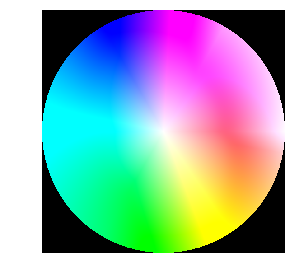

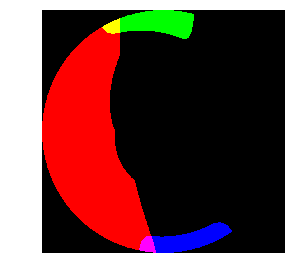

In [8]:
H, C, L = colour.utilities.tsplit(
    RGB_to_HCL(COLOUR_WHEEL_sRGB))

HCL = colour.utilities.tstack([H, tanh_compression_function(C), L])

COLOUR_WHEEL_sRGB_GM_2 = HCL_to_RGB(HCL)

colour.plotting.plot_image(COLOUR_WHEEL_sRGB_GM_2);

colour.plotting.plot_image(np.where(COLOUR_WHEEL_sRGB_GM_2 < 0, 1, 0));

## Hue Slice Ramblings

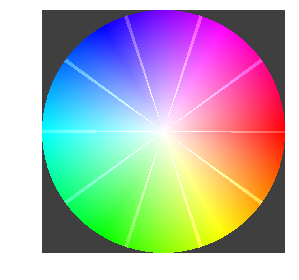

In [9]:
H, S, V = colour.utilities.tsplit(
    colour.RGB_to_HSV(COLOUR_WHEEL))


def hue_slice(H, angle, width=0.0025):
    angle = angle / 360

    S = np.where(np.logical_or(H > angle + width, H < angle - width), 0, 1)

    return S


HUE_SLICES_sRGB = reduce(
    np.add, [hue_slice(H, angle) for angle in np.arange(0, 360, 36)])

colour.plotting.plot_image(
    COLOUR_WHEEL + HUE_SLICES_sRGB[..., np.newaxis] * 0.25);

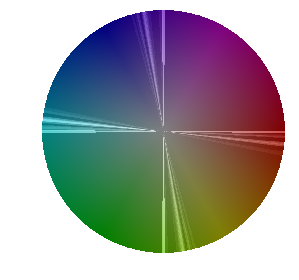

In [10]:
RGB_COLOURSPACES = [
    'ACES2065-1',
    'ACEScg',
    'ALEXA Wide Gamut',
    'Cinema Gamut',
    'DJI D-Gamut',
    'FilmLight E-Gamut',
    'Protune Native',
    'REDcolor',
    'REDcolor2',
    'REDcolor3',
    'REDcolor4',
    'REDWideGamutRGB',
    'DRAGONcolor',
    'DRAGONcolor2',
    'F-Gamut',
    'S-Gamut',
    'S-Gamut3',
    'S-Gamut3.Cine',
    'Venice S-Gamut3',
    'Venice S-Gamut3.Cine',
    'V-Gamut',
    'sRGB'
]


def cumulative_hue_slices(colourspaces=RGB_COLOURSPACES):
    angles = np.arange(0, 360, 90)
    hue_slices = []
    for colourspace in colourspaces:
        colour_wheel = colour.RGB_to_RGB(
            COLOUR_WHEEL,
            colour.RGB_COLOURSPACES[colourspace],
            colour.models.sRGB_COLOURSPACE)
        
        H, S, V = colour.utilities.tsplit(colour.RGB_to_HSV(colour_wheel))

        hue_slices.append(reduce(
            np.add, [hue_slice(H, angle) for angle in angles]))

    hue_slices = colour.utilities.normalise_maximum(reduce(np.add, hue_slices))
    
    return hue_slices


colour.plotting.plot_image(
    COLOUR_WHEEL * 0.5 + cumulative_hue_slices()[..., np.newaxis]);